In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('canada_per_capita_income.csv',index_col = [0], parse_dates = True)
df.head(6)

,per capita income (US$)
year,
1970-01-01,3399.299037
1971-01-01,3768.297935
1972-01-01,4251.175484
1973-01-01,4804.463248
1974-01-01,5576.514583
1975-01-01,5998.144346


In [3]:
df.tail(6)

,per capita income (US$)
year,
2011-01-01,42334.71121
2012-01-01,42665.25597
2013-01-01,42676.46837
2014-01-01,41039.89360
2015-01-01,35175.18898
2016-01-01,34229.19363


In [4]:
df.shape

(47, 1)

In [5]:
##Checking the datetime index
date = pd.date_range (start = '1970', end = '2016', freq = 'M')
date

DatetimeIndex(['1970-01-31', '1970-02-28', '1970-03-31', '1970-04-30',
               '1970-05-31', '1970-06-30', '1970-07-31', '1970-08-31',
               '1970-09-30', '1970-10-31',
               ...
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', length=552, freq='M')

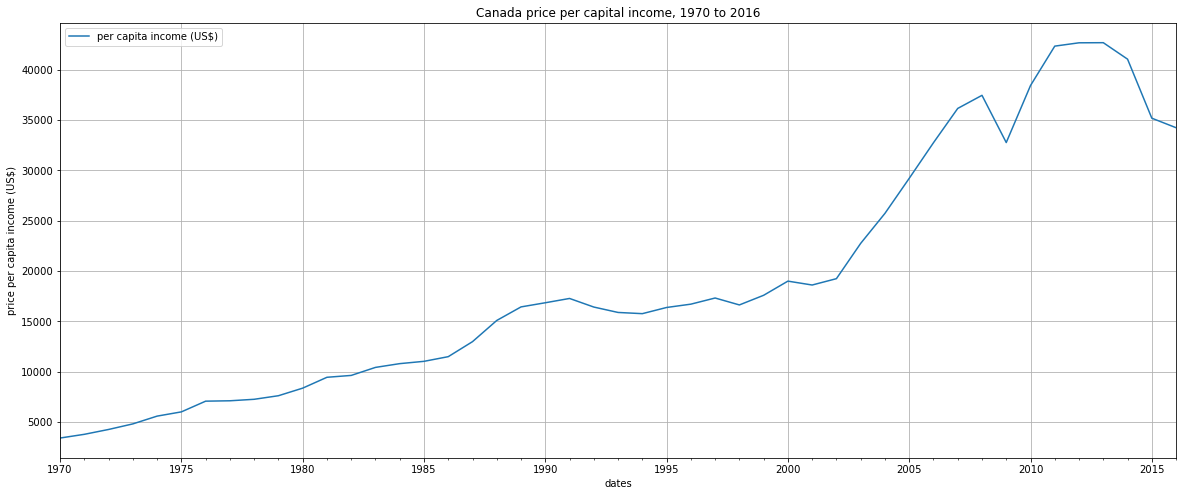

In [6]:
## Using EDA to check the price ratio to date column per 5yrs

df.plot(figsize = (20,8))
plt.title('Canada price per capital income, 1970 to 2016')
plt.xlabel('dates')
plt.ylabel('price per capita income (US$)')
plt.grid();

In [7]:
## checking the full description of the data but rounded to 3 decimal place

round(df.describe(), 3)

,per capita income (US$)
count,47.000
mean,18920.137
std,12034.679
min,3399.299
25%,9526.915
50%,16426.725
75%,27458.601
max,42676.468


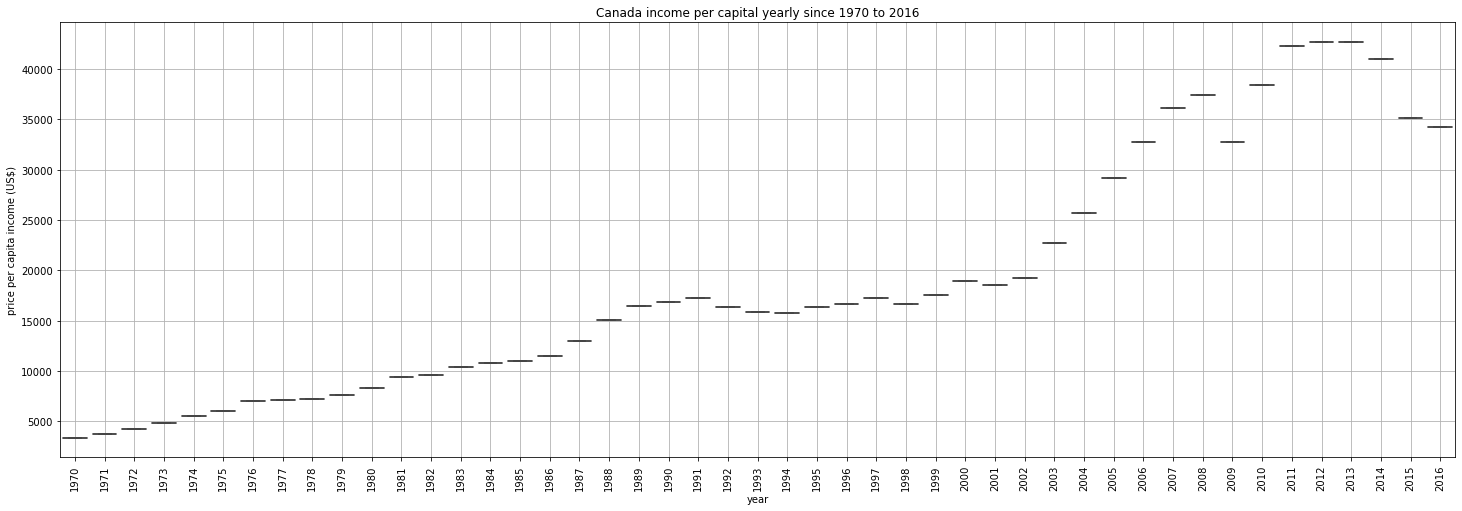

In [8]:
##yearly capital income from 1970 to 2016

_, ax =  plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year, y= df.values[:,0], ax = ax)
plt.title('Canada income per capital yearly since 1970 to 2016')
plt.xlabel('year')
plt.ylabel('price per capita income (US$)')
plt.xticks(rotation = 90)
plt.grid();

In [9]:
from statsmodels.graphics.tsaplots import month_plot

In [10]:
month_plot = df.groupby(df.index.month)[['per capita income (US$)']].mean()
month_plot

,per capita income (US$)
year,
1,18920.137063


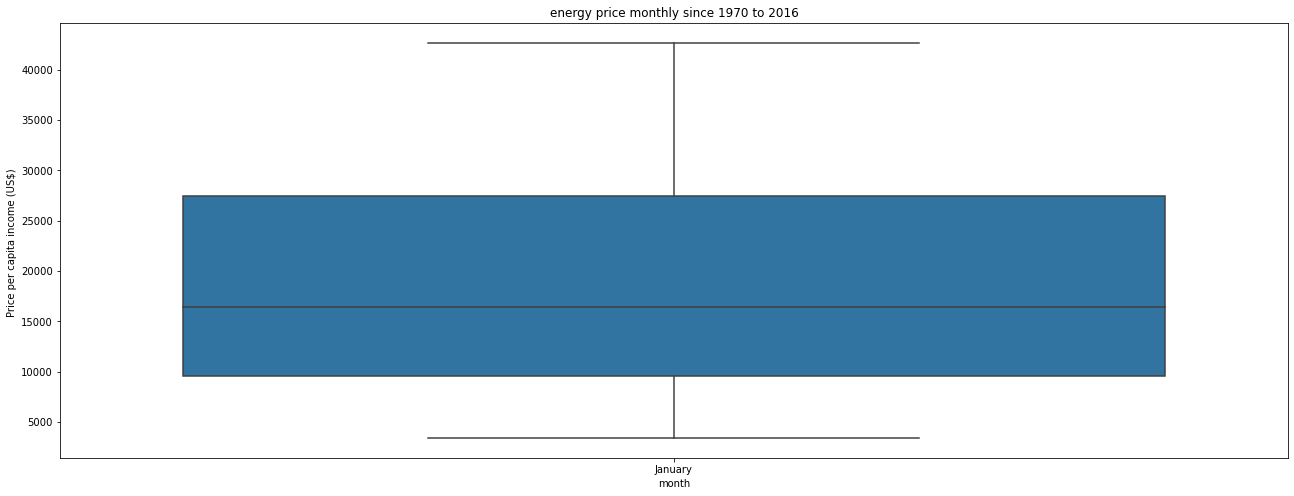

In [11]:
_, ax =  plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(), y= df.values[:, 0], ax=ax)
plt.title('energy price monthly since 1970 to 2016')
plt.xlabel('month')
plt.ylabel('Price per capita income (US$) ')
plt.show();

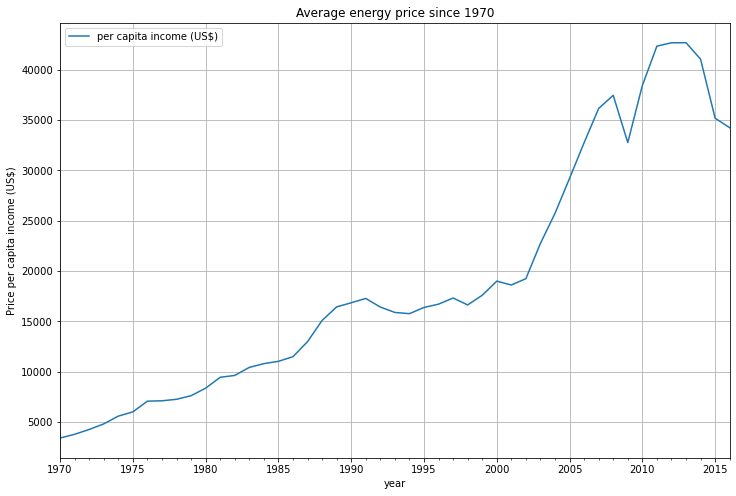

In [12]:
##changing the frequencyn of the data by using a resample code

df_yearly_sum = df.resample('A').mean()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8)) # Increase the figure size here
df_yearly_sum.plot(ax=ax)

plt.title('Average energy price since 1970')
plt.xlabel('year')
plt.ylabel('Price per capita income (US$)')
plt.grid();

In [13]:
df1 = df.groupby(df.index.year).mean()
df1.columns = ['Mean']
df1.head()

,Mean
year,
1970,3399.299037
1971,3768.297935
1972,4251.175484
1973,4804.463248
1974,5576.514583


In [14]:
## getting the overall mean of the data cos data has yearly input with only on month input

overall_std = round(df['per capita income (US$)'].std(ddof=1), 3)
overall_std

12034.679

In [19]:
## creating a time series forcast model

train = df[df.index.year <= 2003]
test = df[df.index.year > 2003]

print(train.shape)
print(test.shape)

(34, 1)
(13, 1)


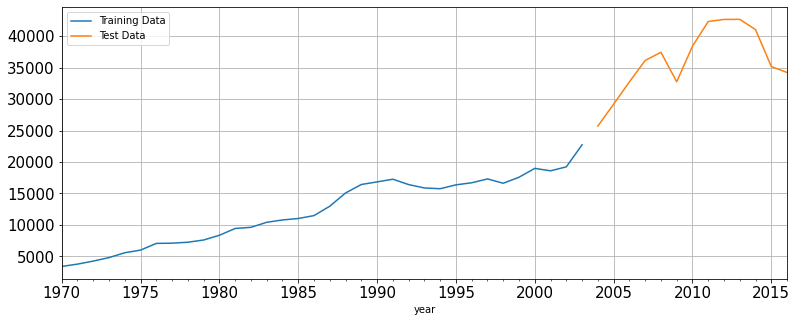

In [20]:
##plot train and test data to confirm split

train['per capita income (US$)'].plot(figsize = (13,5), fontsize = 15)
test['per capita income (US$)'].plot(figsize = (13,5), fontsize = 15)
plt.legend(['Training Data', 'Test Data'])
plt.grid();
plt.show()

In [21]:
## model formation... well do 2 models
## first we'll go for linear regression

train_time = [i+1 for i in range(len(train))] 
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(34, 13)

In [22]:
LR_train = train.copy()
LR_test = test.copy()

In [23]:
##using the linear regression model

LR_train['time'] = train_time
LR_test['time'] = test_time

lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['per capita income (US$)'].values)

LinearRegression()

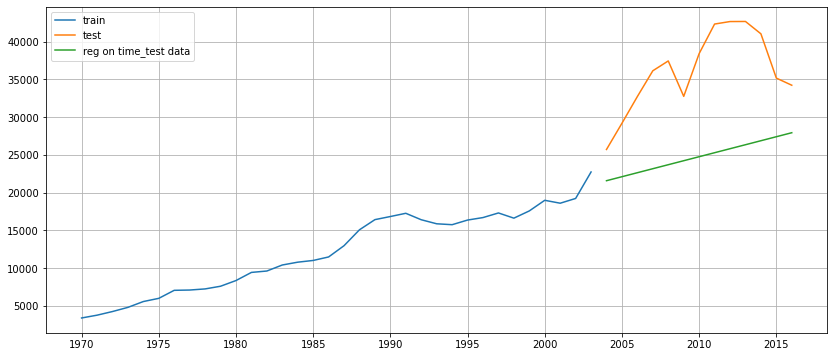

In [24]:
##linear prediction on the test data 

test_predictions_model1 = lr.predict(LR_test[['time']])
LR_test['forcast'] = test_predictions_model1

plt.figure(figsize = (14, 6))
plt.plot(train['per capita income (US$)'], label = 'train')
plt.plot(test['per capita income (US$)'], label = 'test')
plt.plot(LR_test['forcast'], label = 'reg on time_test data')
plt.legend(loc = 'best')
plt.grid();

In [25]:
## we are going to find the MAPE of the dataset

def mape(actual, pred):
    return round((np.mean(abs(actual - pred)/ actual))*100, 2)

In [26]:
mape_model1_test = mape(test['per capita income (US$)'].values,test_predictions_model1)
print('MAPE is %3.3f'%(mape_model1_test), "%" )

MAPE is 30.640 %


In [27]:
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index = ['RegressionOnTime'])
results

,Test Mape (%)
RegressionOnTime,30.64


In [28]:
## DOING THE SAME STEPS ALL OVER AGAIN with another model called NAIVE
##Using a NAIVE model to compare the performance of linear regression on this data set.

Naive_train = train.copy()
Naive_test = test.copy()

Naive_test['naive'] = np.asarray(train['per capita income (US$)'])[len(np.asarray(train['per capita income (US$)']))-1]
Naive_test[['naive']].head()

,naive
year,
2004-01-01,22739.42628
2005-01-01,22739.42628
2006-01-01,22739.42628
2007-01-01,22739.42628
2008-01-01,22739.42628


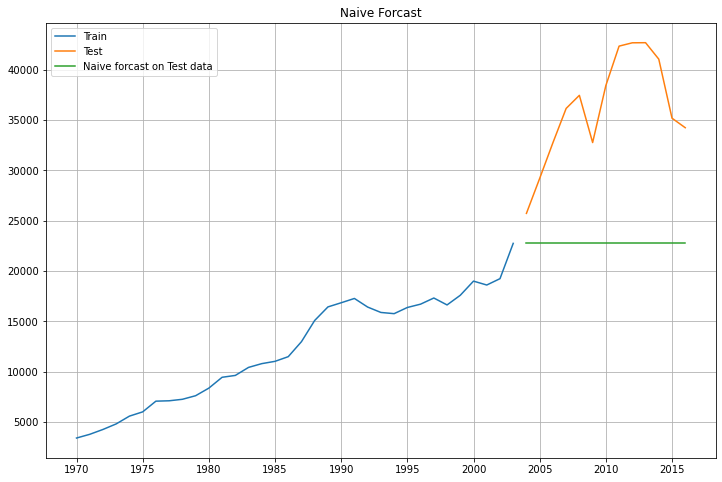

In [29]:
## Naive forecast on the test data

plt.figure(figsize = (12, 8))
plt.plot(Naive_train['per capita income (US$)'], label = 'Train')
plt.plot(test['per capita income (US$)'], label = 'Test')
plt.plot(Naive_test['naive'], label = 'Naive forcast on Test data')
plt.legend(loc = 'best')
plt.title('Naive Forcast')
plt.grid();

In [30]:
##finding the mape using the Naive model so as to compare both Mape values

mape_model2_test = mape(test['per capita income (US$)'].values, Naive_test['naive'].values)
print('for Naive forcast on the Test Data', 'MAPE is %3.3f'%(mape_model2_test), "%" )

for Naive forcast on the Test Data MAPE is 35.790 %


In [31]:
results_naive = pd.DataFrame({'Test MAPE(%)': [mape_model2_test]}, index = ['NaiveModel'])
results = pd.concat([results, results_naive])
results

,Test Mape (%),Test MAPE(%)
RegressionOnTime,30.64,NaN
NaiveModel,NaN,35.79


In [32]:
## Final model using the exponential smoothing

final_model = ExponentialSmoothing(df,
                                  trend = 'additive',
                                  ).fit(smoothing_level = 0.4,
                                                            smoothing_trend = 0.3,
                                                            smoothing_seasonal = 0.6)

In [33]:
## final mape value after smoothing

Mape_final_model = mape(df['per capita income (US$)'].values, final_model.fittedvalues)
print('Mape:', Mape_final_model)

Mape: 7.03


In [34]:
##final forcasting
prediction = final_model.forecast(steps=len(test))

In [37]:
overall_std = round(df['per capita income (US$)'].std(ddof=1), 3)
overall_std

12034.679

In [39]:
##getting the confidience interval for future prediction purpose

pred_df = pd.DataFrame({'lower_CI': prediction - 1.96*np.std(final_model.resid, ddof = 1),
                              'prediction' :prediction,
                              'upper_CI': prediction + 1.96*np.std(final_model.resid, ddof = 1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2017-01-01,32096.657195,37474.902063,42853.146932
2018-01-01,31219.641325,36597.886193,41976.131061
2019-01-01,30342.625455,35720.870323,41099.115191
2020-01-01,29465.609584,34843.854453,40222.099321
2021-01-01,28588.593714,33966.838582,39345.083451


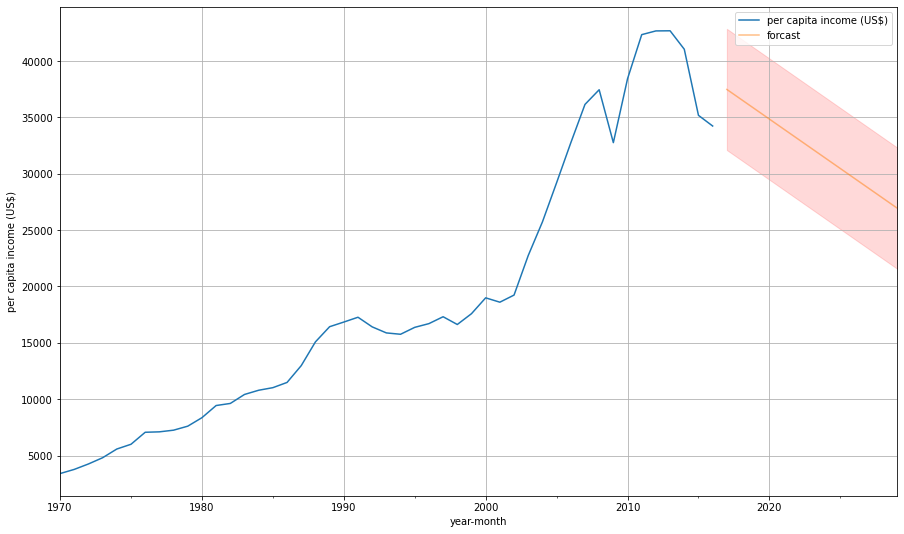

In [44]:
##predicting capital income fir the next 14 years

axis = df.plot(label = 'actual', figsize = (15,9))
pred_df['prediction'].plot(ax = axis, label= 'forcast', alpha =0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color = 'red', alpha = .15)
axis.set_xlabel('year-month')
axis.set_ylabel('per capita income (US$)')
plt.legend(loc = 'best')
plt.grid()
plt.show()